<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   mount google drive
*   change working directory to git repo
*   TPU check



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My\ Drive/PROJECTS/MED/pyCONVCLASSIFIER

/content/gdrive/My Drive/PROJECTS/MED/pyCONVCLASSIFIER


## TPU Check

In [3]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

tf.__version__

TPU address is grpc://10.12.63.10:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 288554394235593309),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8363447992576276839),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14387393449610505226),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13037687303963478661),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3906633802238519242),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3561526314568042039),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5244954904136618396),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14940435475416514770),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 695760421557767

'1.15.0'

# Conv_net Model Training

### Data

In [4]:
from coreLib.utils import readh5
import numpy as np 
class PARAMS:
    DS_DIR  = '/content/gdrive/My Drive/PROJECTS/MED/Train/' # @param
    BATCH_SIZE      = 1024  # @param
    NUM_EPOCHS      = 100  # @param
    IMAGE_DIM       = 64  # @param
    NB_CHANNELS     = 1    # @param
    X_TRAIN_IDEN    = 'X_train.h5'  # @param
    Y_TRAIN_IDEN    = 'Y_train.h5'  # @param
    X_EVAL_IDEN     = 'X_eval.h5'  # @param
    Y_EVAL_IDEN     = 'Y_eval.h5'  # @param
    MODEL_DIR       = '/content/gdrive/My Drive/PROJECTS/MED/MODEL_DIR/' # @param
    MODEL_NAME      = 'conv_net' # @param

X_train=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.X_TRAIN_IDEN))
Y_train=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.Y_TRAIN_IDEN))
X_eval=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.X_EVAL_IDEN))
Y_eval=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.Y_EVAL_IDEN))

X_train=X_train.astype('float32')/255.0
X_eval=X_eval.astype('float32')/255.0

print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(Y_eval.shape)


(25600, 64, 64, 1)
(25600, 2)
(2048, 64, 64, 1)
(2048, 2)


### Compile Model

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import categorical_crossentropy
from coreLib.models import conv_net

resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)
with strategy.scope():
  model=conv_net(img_dim=PARAMS.IMAGE_DIM,nb_channels=PARAMS.NB_CHANNELS)
  model.summary()
  model.compile(optimizer=RMSprop(), 
                loss=categorical_crossentropy,
                metrics=['accuracy'])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.12.63.10:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.12.63.10:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 288554394235593309)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14387393449610505226)
INFO:

### Train

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath=os.path.join(PARAMS.MODEL_DIR,'{}.h5'.format(PARAMS.MODEL_NAME)), 
                               verbose=1, 
                               save_best_only=True)

history=model.fit(X_train,Y_train,
                  validation_data=(X_eval,Y_eval),
                  callbacks=[checkpointer],
                  epochs=PARAMS.NUM_EPOCHS,
                  batch_size=PARAMS.BATCH_SIZE, 
                  verbose=1)

Epoch 1/100
Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 0.6980 - acc: 0.5183INFO:tensorflow:Running validation at fit epoch: 0
INFO:tensorflow:Running validation at fit epoch: 0
2/2 [==============================] - 2s 883ms/step

Epoch 00001: val_loss improved from inf to 0.70710, saving model to /content/gdrive/My Drive/PROJECTS/MED/MODEL_DIR/conv_net.h5

Epoch 00001: val_loss improved from inf to 0.70710, saving model to /content/gdrive/My Drive/PROJECTS/MED/MODEL_DIR/conv_net.h5
25/25 [==============================] - 6s 250ms/step - loss: 0.6967 - acc: 0.5232 - val_loss: 0.7071 - val_acc: 0.5029
Epoch 2/100
Epoch 2/100
22/25 [=========================>....] - ETA: 0s - loss: 0.6939 - acc: 0.5261INFO:tensorflow:Running validation at fit epoch: 1
INFO:tensorflow:Running validation at fit epoch: 1
2/2 [==============================] - 2s 1s/step

Epoch 00002: val_loss improved from 0.70710 to 0.68335, saving model to /content/gdrive/My Drive/PROJECTS/MED/M

### Save Model Weights

In [0]:
model.save_weights(os.path.join(PARAMS.MODEL_DIR,'{}_final.h5'.format(PARAMS.MODEL_NAME)))

### Plot Training Histoty

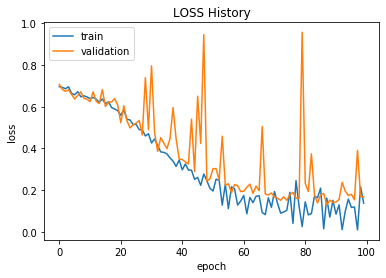

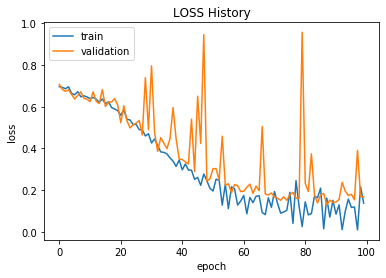

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(PARAMS.MODEL_DIR,'{}_history.png'.format(PARAMS.MODEL_NAME)))